# Linear Regression
with extra varaibles and split data sets

In [1]:
# import libraries
import pandas as pd

import sys
sys.path.append('../0_DataPreparation')
from utils import plot_missing_heatmap

# import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error


In [2]:
# read train and validation data frame from ../data/processed

df_train_clean = pd.read_csv("../data/processed/df_train_data_cleaned.csv")
df_validation_clean = pd.read_csv("../data/processed/df_validation_data_cleaned.csv")
df_test_clean = pd.read_csv("../data/processed/df_test_data_cleaned.csv")

# convert Datum column to datetime
df_train_clean['Datum'] = pd.to_datetime(df_train_clean['Datum'])
df_validation_clean['Datum'] = pd.to_datetime(df_validation_clean['Datum'])
df_test_clean['Datum'] = pd.to_datetime(df_test_clean['Datum'])


# add month to train
df_train_clean['month'] = df_train_clean['Datum'].dt.month
# add month to validation
df_validation_clean['month'] = df_validation_clean['Datum'].dt.month
# add month to test
df_test_clean['month']= df_test_clean['Datum'].dt.month

# print shape of the datasets
print(f"Train data shape: {df_train_clean.shape}")
print(f"Validation data shape: {df_validation_clean.shape}")
print(f"Test data shape: {df_test_clean.shape}")
df_train_clean.head()

Train data shape: (7487, 18)
Validation data shape: (1841, 18)
Test data shape: (1830, 17)


,Datum,KielerWoche_kiwo,Bewoelkung_weather,Temperatur_weather,Windgeschwindigkeit_weather,Warengruppe_umsatz,Umsatz_umsatz,umsatz_rolling7,day_of_week,is_saturday,is_sunday,sunshine_duration,temperature_2m_mean,sunshine_hours,public_holiday,school_holiday,next_day_holiday,month
0,2013-07-01,0.0,6.0,17.8375,15.0,1.0,148.828353,148.828353,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
1,2013-07-01,0.0,6.0,17.8375,15.0,2.0,535.856285,221.786925,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
2,2013-07-01,0.0,6.0,17.8375,15.0,3.0,201.198426,592.534505,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
3,2013-07-01,0.0,6.0,17.8375,15.0,4.0,65.890169,311.369828,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7
4,2013-07-01,0.0,6.0,17.8375,15.0,5.0,317.475875,109.314600,0,0,0,31025.67,15.6,8.618242,0.0,1.0,0.0,7


In [3]:
# ignore some columns
drop_columns = ['Datum', 'umsatz_rolling7','temperature_2m_mean','sunshine_duration','is_saturday','is_sunday']

# drop columns if present
drop_columns = [col for col in drop_columns if col in df_train_clean.columns]

# drop columns from train and validation datasets
df_train_clean = df_train_clean.drop(columns=drop_columns)
df_validation_clean = df_validation_clean.drop(columns=drop_columns)


### Categorial_cols

In [4]:
categorical_cols = ['Warengruppe_umsatz', 'day_of_week','public_holiday','next_day_holiday','month','school_holiday']  # example; replace with actual categoricals
# filter to only those present in the data
categorical_cols = [col for col in categorical_cols if col in df_train_clean.columns]

df_train_clean = pd.get_dummies(df_train_clean, columns=categorical_cols, drop_first=False)  # drop_first=True to avoid multicollinearity if needed
df_validation_clean = pd.get_dummies(df_validation_clean, columns=categorical_cols, drop_first=False)

# ensure train and validation have the same columns (in case of missing categories in validation)
df_validation_clean = df_validation_clean.reindex(columns=df_train_clean.columns, fill_value=0)

In [5]:
correlations_with_target = df_train_clean.corr()['Umsatz_umsatz'].sort_values(ascending=False)
print(correlations_with_target)

Umsatz_umsatz                  1.000000
Warengruppe_umsatz_2.0         0.670450
Warengruppe_umsatz_5.0         0.238443
Temperatur_weather             0.216569
month_8                        0.173527
school_holiday_1.0             0.172477
sunshine_hours                 0.167770
month_7                        0.134890
day_of_week_6                  0.109829
day_of_week_5                  0.097841
next_day_holiday_1.0           0.080972
KielerWoche_kiwo               0.053631
public_holiday_1.0             0.047747
month_6                        0.034507
month_9                        0.012460
Windgeschwindigkeit_weather    0.011454
month_10                       0.006555
month_5                        0.006138
month_4                       -0.012115
day_of_week_4                 -0.027166
day_of_week_3                 -0.036607
month_2                       -0.036918
day_of_week_0                 -0.037176
public_holiday_0.0            -0.047747
day_of_week_2                 -0.050720


In [6]:

# prepare features and target
# assuming 'Umsatz' is the target column
target = 'Umsatz_umsatz'
X_train = df_train_clean.drop(columns=[target])
y_train = df_train_clean[target]
X_validation = df_validation_clean.drop(columns=[target])
y_validation = df_validation_clean[target]

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)


# print learned equation
print("Learned equation:")
equation = f"y = {model.intercept_:.4f}"
for feature, coef in zip(X_train.columns, model.coef_):
    equation += f" + ({coef:.4f}) * {feature}"
print(equation)

# calculate R2 on train and validation
y_train_pred = model.predict(X_train)
y_validation_pred = model.predict(X_validation)

r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train}")
print(f"R2 on validation: {r2_validation}")

# calculate MAPE on validation
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)
print(f"MAPE on validation: {mape_validation}")


Learned equation:
y = 274.4252 + (39.1990) * KielerWoche_kiwo + (-0.5588) * Bewoelkung_weather + (0.1077) * Temperatur_weather + (0.0322) * Windgeschwindigkeit_weather + (0.4876) * sunshine_hours + (-72.5587) * Warengruppe_umsatz_1.0 + (216.6052) * Warengruppe_umsatz_2.0 + (-29.8024) * Warengruppe_umsatz_3.0 + (-105.0483) * Warengruppe_umsatz_4.0 + (86.9648) * Warengruppe_umsatz_5.0 + (-96.1606) * Warengruppe_umsatz_6.0 + (-14.3352) * day_of_week_0 + (-17.2293) * day_of_week_1 + (-19.6679) * day_of_week_2 + (-14.5039) * day_of_week_3 + (-9.8477) * day_of_week_4 + (35.2386) * day_of_week_5 + (40.3452) * day_of_week_6 + (-38.8911) * public_holiday_0.0 + (38.8911) * public_holiday_1.0 + (-39.6085) * next_day_holiday_0.0 + (39.6085) * next_day_holiday_1.0 + (-31.7142) * month_1 + (-7.7804) * month_2 + (-21.3786) * month_3 + (-24.4957) * month_4 + (-1.5653) * month_5 + (8.2308) * month_6 + (46.0475) * month_7 + (67.9220) * month_8 + (12.3947) * month_9 + (-4.2666) * month_10 + (-22.5939) * 

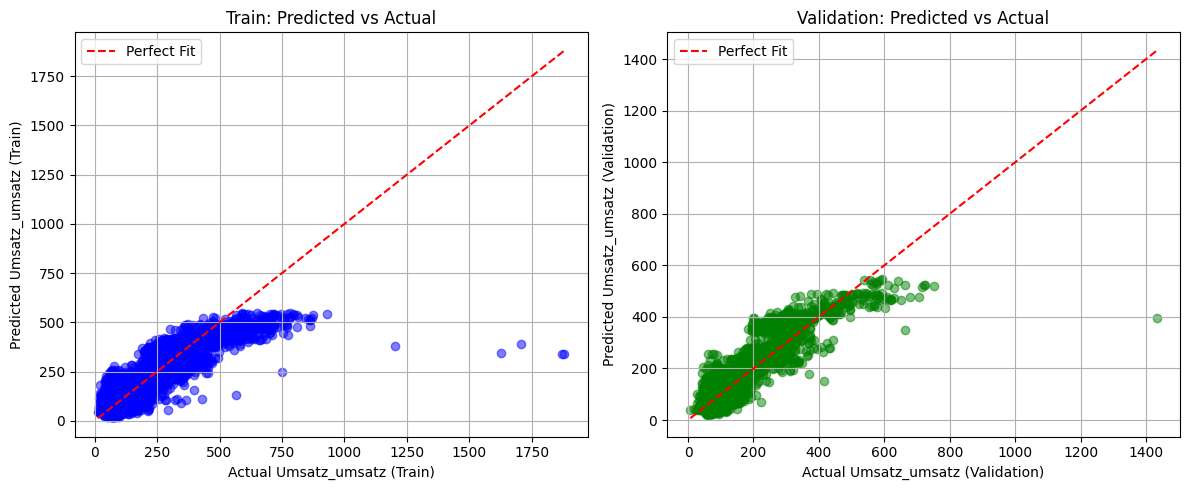

In [7]:
# plot the equation
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# train plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

# validation plot
axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## PolynomialFeature
Captures Non-Linearity: If features like temperature or holidays have quadratic effects on sales, polynomial terms (e.g., x²) fit curves.
- Simple Extension: Still uses LinearRegression, but on transformed features.
- Risks: Higher degrees increase complexity/overfitting; monitor validation R².

Learned equation for polynomial regression:
y = 270.1916 + (25.1972) * KielerWoche_kiwo + (2.0252) * Bewoelkung_weather + (-2.5081) * Temperatur_weather + (-0.4021) * Windgeschwindigkeit_weather + (1.1232) * sunshine_hours + (-38.5582) * Warengruppe_umsatz_1.0 + (75.1553) * Warengruppe_umsatz_2.0 + (-15.0888) * Warengruppe_umsatz_3.0 + (-30.8370) * Warengruppe_umsatz_4.0 + (56.1207) * Warengruppe_umsatz_5.0 + (-46.7920) * Warengruppe_umsatz_6.0 + (5.2207) * day_of_week_0 + (3.4457) * day_of_week_1 + (3.5069) * day_of_week_2 + (0.4512) * day_of_week_3 + (0.9424) * day_of_week_4 + (-8.2405) * day_of_week_5 + (-5.3264) * day_of_week_6 + (2.0484) * public_holiday_0.0 + (-2.0484) * public_holiday_1.0 + (-33.1288) * next_day_holiday_0.0 + (33.1288) * next_day_holiday_1.0 + (-7.3448) * month_1 + (-1.8727) * month_2 + (-18.2064) * month_3 + (0.9099) * month_4 + (13.9671) * month_5 + (15.8070) * month_6 + (13.6068) * month_7 + (0.5492) * month_8 + (-9.8990) * month_9 + (-18.8944) * month_10 + (

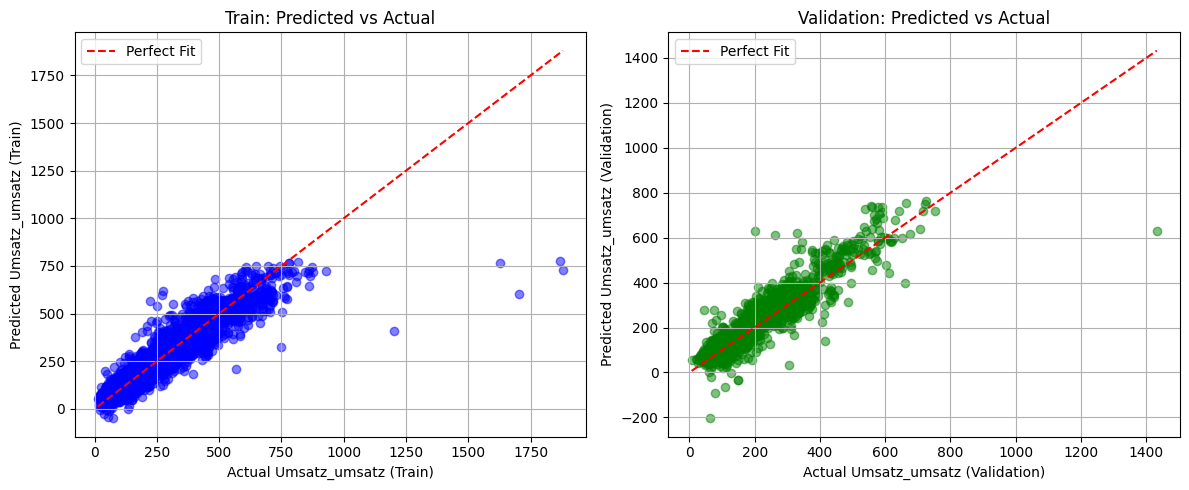

In [8]:
# ...existing code...

from sklearn.preprocessing import PolynomialFeatures

# prepare features and target
target = 'Umsatz_umsatz'
X_train = df_train_clean.drop(columns=[target])
y_train = df_train_clean[target]
X_validation = df_validation_clean.drop(columns=[target])
y_validation = df_validation_clean[target]

# add polynomial features (degree 2 for quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_validation_poly = poly.transform(X_validation)

# fit polynomial regression (still LinearRegression on transformed features)
model = LinearRegression()
model.fit(X_train_poly, y_train)

print("Learned equation for polynomial regression:")
equation = f"y = {model.intercept_:.4f}"
feature_names = poly.get_feature_names_out(X_train.columns)
for feature, coef in zip(feature_names, model.coef_):
    equation += f" + ({coef:.4f}) * {feature}"
print(equation)

# predict
y_train_pred = model.predict(X_train_poly)
y_validation_pred = model.predict(X_validation_poly)

# evaluate
r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train:.4f}")
print(f"R2 on validation: {r2_validation:.4f}")
print(f"MAPE on validation: {mape_validation:.4f}")

# plot predicted vs actual (same as before)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ...existing code...